In [ ]:
# 필요한 모델 임포트

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import make_scorer, mean_absolute_percentage_error

# **1. 데이터 불러오기**
- 실행 환경) Google Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/2024 BDA 연합공모전_코인채굴꾼/final/modeling/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/2024 BDA 연합공모전_코인채굴꾼/final/modeling/test.csv')

## **1-1. 기본 정보 확인**

In [ ]:
train.isna().sum().sum()

0

In [ ]:
test.isna().sum().sum()

0

In [ ]:
train.head()

,Time,Open,High,Low,Close,Volume,BHB,BLB,ATR,KCH,...,MFI,ADI,OBV,CMF,FI,EOM_EMV,VPT,NVI,VMAP,volatility
0,2023-01-01 20:00:00,16596.1,16618.8,16592.0,16593.8,4951.995,16595.002450,16498.327550,26.981517,16572.478333,...,72.939470,2159.219408,28161.985,0.009412,32147.018270,2.922459e+06,17.119384,1000.618732,16554.907495,0.000824
1,2023-01-01 21:00:00,16593.7,16599.7,16584.1,16597.6,3040.626,16602.225710,16495.824290,26.168552,16574.291667,...,79.464356,4381.215331,31202.611,0.007622,29205.212632,-6.926205e+06,17.815691,1000.847875,16562.199662,0.000773
2,2023-01-01 22:00:00,16597.6,16605.4,16579.1,16594.4,3633.682,16608.248983,16495.001017,26.177941,16576.901667,...,79.022963,4975.315430,27568.929,0.022697,23371.927627,2.533243e+05,17.115121,1000.847875,16566.545112,0.000763
3,2023-01-01 23:00:00,16594.4,16617.4,16594.4,16610.3,5040.212,16616.744923,16494.605077,25.950945,16580.598333,...,79.376771,6903.744369,32609.141,0.041957,31481.562366,6.228905e+06,21.944423,1000.847875,16572.330357,0.000749
4,2023-01-02 00:00:00,16610.4,16618.4,16572.9,16578.0,5774.202,16617.897103,16499.472897,27.347306,16585.331667,...,71.354508,2423.978862,26834.939,-0.001321,340.378514,-8.076874e+06,10.716045,1000.847875,16575.920893,0.000873


In [ ]:
test.head()

,Time,Open,High,Low,Close,Volume,BHB,BLB,ATR,KCH,...,PVO,MFI,ADI,OBV,CMF,FI,EOM_EMV,VPT,NVI,VMAP
0,2024-01-28 00:00:00,43687.889385,43774.443251,43572.783759,43676.482068,11886.490259,42784.665608,41022.512599,275.445999,42055.133126,...,-10.293702,86.493832,4.943594e+06,3.726688e+06,0.034947,2.865403e+06,2.659440e+09,47494.660194,1876.852503,42218.237697
1,2024-01-28 01:00:00,43695.494754,43778.816738,43579.826930,43680.607316,10068.745370,43168.834053,40831.584885,269.984842,42151.933466,...,-4.740666,87.858203,4.943724e+06,3.736757e+06,0.055399,2.461994e+06,1.128144e+07,47495.611188,1877.029772,42435.078289
2,2024-01-28 02:00:00,43698.990073,43776.451039,43585.969985,43682.067833,7363.994556,43468.245797,40730.899925,264.306000,42252.795666,...,-3.655645,88.565649,4.943790e+06,3.744121e+06,0.077071,2.111817e+06,4.885356e+06,47495.857412,1877.092532,42578.500019
3,2024-01-28 03:00:00,43699.553413,43770.121091,43592.931136,43682.942544,7193.953852,43716.409710,40681.120266,258.083425,42355.656744,...,-2.963789,89.221985,4.943905e+06,3.751315e+06,0.041690,1.811027e+06,7.773390e+05,47496.001468,1877.130120,42700.394603
4,2024-01-28 04:00:00,43700.158038,43766.070468,43599.270780,43685.036170,5881.505407,43917.982730,40702.510863,251.563159,42455.899685,...,-3.917382,89.496148,4.944072e+06,3.757196e+06,0.121557,1.554068e+06,3.245836e+06,47496.283355,1877.220087,42811.827260


In [ ]:
# Time 삭제

train.drop('Time',inplace=True,axis=1)
test.drop('Time',inplace=True,axis=1)

In [ ]:
print(train.shape)
print(test.shape)

(9388, 49)
(73, 48)


## **1-2. Features,Target 나누기**

In [ ]:
X_train = train.drop('volatility',axis=1,inplace=False)
y_train = train['volatility']

In [ ]:
X_test = test.copy()

In [ ]:
print(X_train.shape, y_train.shape, X_test.shape)

(9388, 48) (9388,) (73, 48)


## **1-3. 스케일링**

In [ ]:
from sklearn.preprocessing import StandardScaler

train_cols = X_train.columns
test_cols = X_test.columns

# StandardScaler 객체 생성
scaler = StandardScaler()

# Train 데이터를 스케일링하고 변환
X_train = scaler.fit_transform(X_train)
# Test 데이터를 Train 데이터의 평균과 표준편차를 이용해 스케일링하고 변환
X_test = scaler.transform(X_test)

## 데이터프레임으로 다시 저장
X_train = pd.DataFrame(X_train, columns=train_cols)
X_test = pd.DataFrame(X_test, columns=test_cols)

In [ ]:
X_train.head()

,Open,High,Low,Close,Volume,BHB,BLB,ATR,KCH,KCL,...,PVO,MFI,ADI,OBV,CMF,FI,EOM_EMV,VPT,NVI,VMAP
0,-1.964943,-1.967364,-1.960535,-1.965775,-0.583897,-1.984544,-1.949616,-1.572068,-1.976415,-1.962995,...,0.432335,1.245784,-2.893488,-3.524944,-0.116041,-0.009982,0.002141,-3.039398,-1.792675,-1.971481
1,-1.965300,-1.970195,-1.961716,-1.965209,-0.677284,-1.983487,-1.949995,-1.579957,-1.976148,-1.962503,...,0.233652,1.603982,-2.891492,-3.521822,-0.130656,-0.010729,-0.043612,-3.039346,-1.791532,-1.970395
2,-1.964720,-1.969350,-1.962464,-1.965685,-0.648308,-1.982606,-1.950119,-1.579866,-1.975763,-1.962171,...,0.122833,1.579751,-2.890958,-3.525553,-0.007574,-0.012210,-0.010259,-3.039398,-1.791532,-1.969747
3,-1.965196,-1.967572,-1.960176,-1.963319,-0.579586,-1.981362,-1.950179,-1.582069,-1.975217,-1.961548,...,0.162130,1.599174,-2.889225,-3.520378,0.149687,-0.010151,0.017501,-3.039040,-1.791532,-1.968885
4,-1.962815,-1.967424,-1.963391,-1.968126,-0.543724,-1.981194,-1.949443,-1.568518,-1.974518,-1.961196,...,0.257035,1.158774,-2.893250,-3.526307,-0.203678,-0.018055,-0.048957,-3.039874,-1.791532,-1.968350


In [ ]:
X_test.head()

,Open,High,Low,Close,Volume,BHB,BLB,ATR,KCH,KCL,...,PVO,MFI,ADI,OBV,CMF,FI,EOM_EMV,VPT,NVI,VMAP
0,2.066734,2.057148,2.073522,2.064696,-0.245085,1.847433,1.757489,0.839078,1.784561,1.827347,...,-0.367930,1.989881,1.546807,0.272677,0.092454,0.709137,12.343090,0.486242,2.577372,1.852862
1,2.067866,2.057796,2.074575,2.065310,-0.333898,1.903643,1.728628,0.786082,1.798847,1.841297,...,-0.074604,2.064781,1.546924,0.283016,0.259441,0.606746,0.040973,0.486313,2.578256,1.885176
2,2.068386,2.057446,2.075494,2.065528,-0.466049,1.947452,1.713408,0.730973,1.813734,1.855558,...,-0.017290,2.103618,1.546984,0.290577,0.436390,0.517867,0.011259,0.486331,2.578569,1.906548
3,2.068470,2.056508,2.076535,2.065658,-0.474357,1.983762,1.705883,0.670588,1.828915,1.870299,...,0.019256,2.139649,1.547087,0.297964,0.147506,0.441522,-0.007825,0.486342,2.578756,1.924713
4,2.068560,2.055907,2.077482,2.065969,-0.538482,2.013256,1.709117,0.607314,1.843710,1.887664,...,-0.031116,2.154700,1.547237,0.304003,0.799623,0.376302,0.003643,0.486363,2.579205,1.941319


# **2. RandomForest 모델링**

- 사이킷런 패키지 활용하면 됨

## **2-1. Feature Selection**

### **a) Feature Importance**

In [ ]:
rf_base = RandomForestRegressor()
rf_base.fit(X_train, y_train)

RandomForestRegressor()

### **Feature Importance 확인**
- 주요 변수 상위 20개만 확인

<ipython-input-18-e291736dc283>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = feature_top20, y = feature_top20.index, palette=colors)


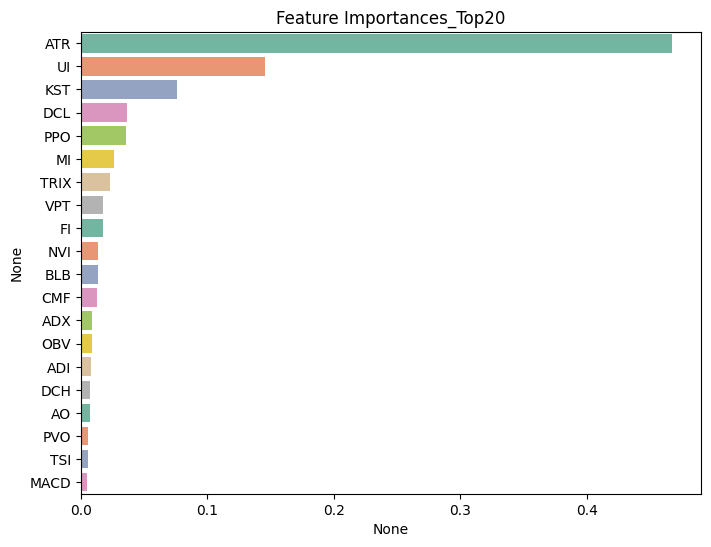

In [ ]:
feature_importances_values = rf_base.feature_importances_
feature_importances = pd.Series(feature_importances_values, index = X_train.columns)
feature_top20 = feature_importances.sort_values(ascending = False)[:20]

plt.figure(figsize = (8, 6))
colors = sns.color_palette("Set2", n_colors=len(feature_top20))
sns.barplot(x = feature_top20, y = feature_top20.index, palette=colors)
plt.title('Feature Importances_Top20')
plt.show()

### **b) RFECV(Recursive Feature Elimination with Cross-Validation)**

- 사용자가 지정한 모델을 기반으로 교차 검증을 수행하면서 중요하지 않은 특성을 제거하는 방식
  - 사용자가 지정한 모델에서 특성 중요도를 평가하여 feature 선택
- 특성을 순차적으로 제거하면서 교차 검증을 통해 성능을 평가하고, 최적의 특성 수를 찾음
  - 사용자가 지정한 교차 검증의 폴드 수, 평가 지표에 따라 평가
  - 교차 검증을 통해 최적의 특성 수를 자동으로 결정

In [ ]:
# 성능지표 MAPE
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better = False)

# 시계열 교차 검증
tscv = TimeSeriesSplit(n_splits = 5)

# 모델 정의
rf_model = RandomForestRegressor()

# RFECV를 사용하여 중요한 특성 선택
rfecv = RFECV(estimator = rf_model, step = 1, cv = tscv, scoring = mape_scorer)
rfecv.fit(X_train, y_train)

RFECV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
      estimator=RandomForestRegressor(),
      scoring=make_scorer(mean_absolute_percentage_error, greater_is_better=False))

In [ ]:
# 선택된 특성 확인
selected_features = X_train.columns[rfecv.support_]
print("Selected Features:")
print(selected_features.tolist())

Selected Features:
['BLB', 'ATR', 'DCL', 'UI', 'MI', 'KST', 'PPO', 'VPT']


- Feature Importance와 RFECV 방식을 통해 최종적으로 상위 10개 feature 선택  
  => ['ATR', 'UI', 'KST', 'DCL', 'PPO', 'MI', 'TRIX', 'VPT', 'FI', 'BLB']

## **2-2. 모델링**

In [ ]:
### Feature 선택

X_train = X_train[['ATR', 'UI', 'KST', 'DCL', 'PPO', 'MI', 'TRIX', 'VPT', 'FI', 'BLB']]
X_test = X_test[['ATR', 'UI', 'KST', 'DCL', 'PPO', 'MI', 'TRIX', 'VPT', 'FI', 'BLB']]

In [ ]:
print(X_train.shape, y_train.shape, X_test.shape)

(9388, 10) (9388,) (73, 10)


In [ ]:
### 모델 최적화

## 모델 정의
model = RandomForestRegressor(n_jobs = -1)

## GridSearch - 하이퍼파라미터 조정
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# 시계열 교차 검증
tscv = TimeSeriesSplit(n_splits = 5)

# 성능 평가 지표
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better = False)

grid_search = GridSearchCV(estimator = model, param_grid = param_grid, scoring = mape_scorer, cv = tscv, n_jobs = -1)
grid_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 및 성능 출력
print("Best Hyperparameters:", grid_search.best_params_)
print("Best MAPE on Training Data:", -grid_search.best_score_)

Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Best MAPE on Training Data: 0.23187433949552946


# **3. Volatility 예측**

In [ ]:
# 최적의 모델 선택
best_model = grid_search.best_estimator_

In [ ]:
y_pred = best_model.predict(X_test)
y_pred

array([0.00484466, 0.00480231, 0.004807  , 0.0049046 , 0.00496558,
       0.00492404, 0.00493237, 0.00489877, 0.00492111, 0.00478982,
       0.00469213, 0.00453157, 0.00456778, 0.0045578 , 0.00487005,
       0.00517986, 0.00517279, 0.00512139, 0.00497775, 0.00475363,
       0.00470303, 0.00468743, 0.00464726, 0.00458314, 0.0045842 ,
       0.00458624, 0.00455157, 0.00440855, 0.0042453 , 0.00410438,
       0.00408263, 0.00405407, 0.00406571, 0.00402226, 0.00402915,
       0.00404016, 0.00405723, 0.00409312, 0.00419307, 0.00423959,
       0.00426366, 0.0042797 , 0.00434593, 0.00436765, 0.00442104,
       0.00442467, 0.00442889, 0.0044354 , 0.00441683, 0.00440872,
       0.00436216, 0.00435162, 0.00433297, 0.00430601, 0.00429145,
       0.00426215, 0.00426943, 0.00427388, 0.00428453, 0.00425923,
       0.00427549, 0.00427512, 0.00427049, 0.00426354, 0.00428211,
       0.00425572, 0.00424936, 0.00427913, 0.00424722, 0.00425145,
       0.00422657, 0.00422657, 0.00423679])

In [ ]:
len(y_pred)

73

# **4. submission 파일 생성**

In [ ]:
sample_submission = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/2024 BDA 연합공모전_코인채굴꾼/sample_submission.csv', index_col = 0)
sample_submission

,pred_volatility
2024-01-28 0:00,0
2024-01-28 1:00,0
2024-01-28 2:00,0
2024-01-28 3:00,0
2024-01-28 4:00,0
...,...
2024-01-30 20:00,0
2024-01-30 21:00,0
2024-01-30 22:00,0
2024-01-30 23:00,0


In [ ]:
sample_submission['pred_volatility'] = np.array(y_pred)
sample_submission

,pred_volatility
2024-01-28 0:00,0.004845
2024-01-28 1:00,0.004802
2024-01-28 2:00,0.004807
2024-01-28 3:00,0.004905
2024-01-28 4:00,0.004966
...,...
2024-01-30 20:00,0.004247
2024-01-30 21:00,0.004251
2024-01-30 22:00,0.004227
2024-01-30 23:00,0.004227


In [ ]:
sample_submission.to_csv('/content/drive/MyDrive/Colab Notebooks/2024 BDA 연합공모전_코인채굴꾼/final/[ASCENDxBDA]submission.csv')